# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [3]:
import pandas as pd
import numpy as np
import math
import json

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [27]:
event_types = transcript['event'].unique()
event_types

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [26]:
event_types

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

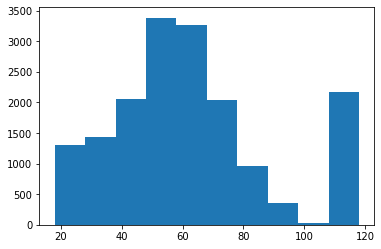

In [28]:
plt.hist(profile['age'])
plt.show()

In [16]:
oneeighteen = profile[profile['age'] == 118]
notthat = profile[profile['age'] != 118]

In [17]:
print(notthat.shape)
oneeighteen.shape

(14825, 5)


(2175, 5)

In [18]:
oneeighteen.describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


In [19]:
notthat.describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [20]:
oneeighteen['gender'].unique()

array([None], dtype=object)

In [21]:
notthat['gender'].unique()

array(['F', 'M', 'O'], dtype=object)

What do you do with 2000 genderless 118 year-olds with no income? Asking for a friend.

Corollary: if you aren't 118, you have a valid income and gender. I think we can, for now, just look at the 118 year-olds as a separate (identical) population. Regardless, I really should start pulling out some testing data. I'm not sure yet whether I'll do it based on time or individuals, so let's keep looking.

So in part this is going to be about targeting: how to take these existing interventions and make them effective. However, I'm interested in whether we can target based on past behavior, time between receiving and viewing offer, etc. I'd rather not rely on age too much, and targeting something with financial implications like bogo or a discount based on gender seems less than ideal on a number of levels. However, studying the influence of protected attributes can provide feedback to the people designing offers even if no targeting is involved. If these offers work better on men over 50, how can these offers be changed to better serve other demographics?

In [4]:
offer_receipts = transcript[(transcript['event'] == 'offer received')]

In [44]:
offer_receipts.loc[:, 'value'] = offer_receipts['value'].apply(lambda d: d['offer id'])

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [66]:
offer_receipts.drop_duplicates(subset=['time', 'value'])

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0
5,389bc3fa690240e798340f5a15918d5c,offer received,f19421c1d4aa40978ebb69ca19b0e20d,0
6,c4863c7985cf408faee930f111475da3,offer received,2298d6c36e964ae4a3e7e9706d1fb8c2,0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,3f207df678b143eea3cee63160fa8bed,0
12,4b0da7e80e5945209a1fdddfe813dbe0,offer received,ae264e3637204a6fb9bb56bc8210ddfd,0
31,be8a5d1981a2458d90b255ddc7e0d174,offer received,5a8bc65990b245e5a138643cd4eb9837,0


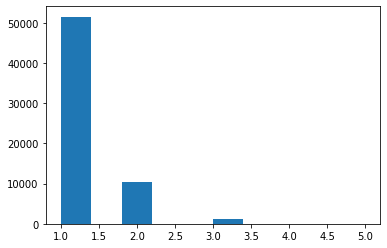

In [54]:
offer_counts = offer_receipts.groupby(['person', 'value']).count().drop('time', axis=1)
plt.hist(offer_counts['event'])
plt.show()

In [70]:
frequent_offers = offer_counts[offer_counts['event'] > 4].reset_index()
frequent_offers

,person,value,event
0,23d67a23296a485781e69c109a10a1cf,5a8bc65990b245e5a138643cd4eb9837,5
1,2ea50de315514ccaa5079db4c1ecbc0b,fafdcd668e3743c1bb461111dcafc2a4,5
2,43a50d7e5c8547a9aa1ec31291b9fc30,0b1e1539f2cc45b7b9fa7c272da2e1d7,5
3,6d2db3aad94648259e539920fc2cf2a6,f19421c1d4aa40978ebb69ca19b0e20d,5
4,eece6a9a7bdd4ea1b0f812f34fc619d6,5a8bc65990b245e5a138643cd4eb9837,5


In [69]:
portfolio[portfolio['id'].isin(frequent_offers['value'].unique())]

,reward,channels,difficulty,duration,offer_type,id
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d


In [71]:
notthat[notthat['id'].isin(frequent_offers['person'].unique())]

,gender,age,id,became_member_on,income
2036,M,82,6d2db3aad94648259e539920fc2cf2a6,20180411,65000.0
7719,M,48,43a50d7e5c8547a9aa1ec31291b9fc30,20171118,57000.0
11673,M,38,23d67a23296a485781e69c109a10a1cf,20140602,48000.0
11723,M,69,eece6a9a7bdd4ea1b0f812f34fc619d6,20180201,65000.0


In [73]:
oneeighteen[oneeighteen['id'].isin(frequent_offers['person'].unique())]

,gender,age,id,became_member_on,income
7708,None,118,2ea50de315514ccaa5079db4c1ecbc0b,20151218,NaN


In [39]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [34]:
transcript.shape

(306534, 4)

In [74]:
transcript['person'].unique().size

17000

In [76]:
profile['id'].unique().size

17000

In [64]:
transcript.tail()

,person,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [30]:
event_types

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

So we're looking at a little over 4 weeks of data (specifically, there's an extra two days), with offers at the beginning of every week (0, 1, 2, and 3) and halfway-ish through week 2 and week 3, with every type of offer being given at every offering event. It's not clear what day of the week the offers are received on, but there are 4 on one day and 2 on another for 6 total days. It's not uncommon to receive the same offer twice (regardless of which offer), but only 4 offers are given 5 times. No obvious commonality, although it's possible they were all given through email. There is no way to verify which channels an offer went through, but we can encode possible channels as a feature of an offer and see whether that implies anything. Each one of the 17,000 customers is represented in the transcripts, including our 2000 supercentenarians. Let me just check when people come in.

In [79]:
transcript[transcript['time'] <= 168]['person'].unique().size

16517

Most people are in by the second round of offers. Now as far as training goes, I'd like to be predicting forward in time, and we could reserve a quarter of the dataset for training. Let's consider not using any events past a particular threshold. Our main obstacle here is the two long promotions, wherein you still have some time to complete the offer when you may have received another. Just for reference, let's see if any were completed in the first 3 days of the 3rd week.

In [80]:
transcript[(transcript['time'] >= 504) & (transcript['time'] < 576) & (transcript['event'] == 'offer completed')]

,person,event,value,time
214282,b7a66e629b134079a9bc7120c7b9947b,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,504
214288,4264b1d027cc493281bba4f44bfedaca,offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,504
214304,c87b50fcdd4a4d2faacff6112243a8dd,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,504
214318,c894971c9e414a358b84255199727636,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,504
214320,e277228d77a64ab896d6dd6d88f970d3,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,504
...,...,...,...,...
245096,439493c46a814ea6928f444db5eff0aa,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,570
245101,7fc83dab9a6844ca82aca3f72e2e9c43,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,570
245109,435afc43755d4bd5ab56ec38dcc152ff,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,570
245118,d9ca82f550ac4ee58b6299cf1e5c824a,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,570


A ton! This whole thresholding thing is a challenge. Well, let's at least clean the data while we think. We need to further explore this overlap. If we're choosing an offer to give (which seems like the best way to model the scenario), we'd like to make sure that offers did not overlap, and we'd like to control for the influence of prior offers. Of course, I don't really want to break this down pairwise, but we could do something like "completed last offer". I think the first step is to split off the transaction data, since that will exist independently of everything else. Then we can talk about how to structure the offers data.

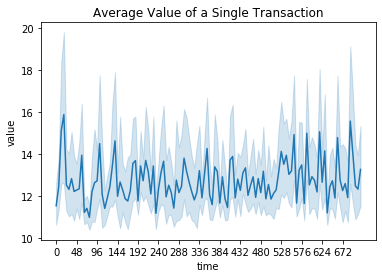

In [138]:
transactions = transcript[transcript['event'] == 'transaction'].drop('event', axis=1)
transactions['value'] = transactions['value'].apply(lambda d: d['amount'])
sns.lineplot(x='time', y='value', data=transactions)
plt.xticks(np.arange(0, 714, 48))
plt.title('Average Value of a Single Transaction')
plt.show()
transactions = transactions.pivot(index='person', columns='time').fillna(0)
transactions.columns = transactions.columns.droplevel()

At least, it's not clear that the average transaction amount shifts over the course of time or that people make particularly large purchases on weekends (not that we would care too much if they did in this case). However, we also want to know about patterns in actual amount spent, and this plot is conditioned on the existence of a purchase.

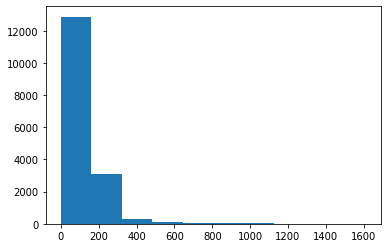

In [112]:
plt.hist(transactions.sum(axis=1))
plt.show()

In [118]:
offer_receipts['time'].unique()

array([  0, 168, 336, 408, 504, 576], dtype=int64)

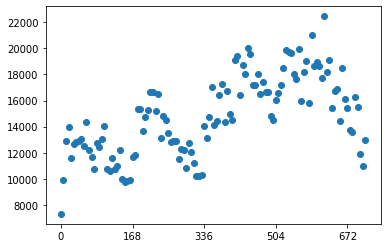

In [117]:
plt.scatter(transactions.columns, transactions.sum())
plt.xticks([0, 168, 336, 504, 672])
plt.show()

In [140]:
transcript[transcript['time'] <= 168]['person'].unique().size / profile.shape[0]

0.9715882352941176

The distribution on total spending for a given user is not too surprising, and also spending is clearly following cyclical weekly patterns. Most of the offers are given right at the bottom of the cycle (or whenever it starts to tick up). I don't have an immediate guess as to what day that is, but it does look like we can expect the midweek offers to look substantively different from the weekly offers. Given that we only have two of those and 97% of users show up within the first week, I'm more comforable segmenting on users and calling this a solid block of time. Certainly when we predict we're only going to use features that were available at the time, but the fact that these trends overlap means we'll have some information we shouldn't have so it will be an overestimate of performance. Just something to keep in mind.

In [141]:
(transcript['event'] == 'offer viewed').sum() / (transcript['event'] == 'offer received').sum()

0.7567812053436815

Now, we want to consider time under the influence of the promotion. That's between offer viewed and the time the offer is completed or no longer applicable, as it compares to time not under the influence. We don't exactly have any baseline data, but it's worth noting that app users are expected to be receiving these offers constantly. This is time series stuff, and we might be interested in the size of purchases and the gaps between them. So many questions! There should be some sort of memory component (exponentially weighted for transactions and maybe just a fixed window for offer receipt and offer completion). The last thing to note is that offer completion is... fine, but not necessarily the most desired outcome? It really depends on what the profit margin is, but if you get a deal (say, "buy two lattes in the next 4 days and get one free") and it causes an increase in spending but not enough to complete the offer (something I myself have done), that seems to be a decent outcome. The other thought is whether we should always use a fixed window size, or check in some other way. The idea is that if an offer causes you to frontload your purchases, there's nothing particularly good about that. It's a little difficult to prove this either way. Still, maybe we can initially compare behavior under the influence vs not, but hmm. How would you even check? Spending behavior of people who complete their offers vs those who don't? It's a little dubious! I mean with specific offers they're much easier to evaluate. Unfortunately everyone seems to be under the influence, and "people who don't look at their offers shouldn't get them" seems like a reasonable first approximation. We could identify that 25%, but I really want a metric of some kind.

In [5]:
offer_receipts.shape

(76277, 4)

In [6]:
17000 * 5

85000

In [8]:
non_first_offers = set(profile['id']) - set(transcript[transcript['time'] == 0]['person'].unique())

In [9]:
len(non_first_offers)

4239

In [12]:
profile[profile['id'].isin(non_first_offers)]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN
11,None,118,148adfcaa27d485b82f323aaaad036bd,20150919,NaN
...,...,...,...,...,...
16968,M,74,2c6f50c1c07a444896e2a4e31d724f92,20170725,87000.0
16973,M,30,08eb126ad33f447ca3ad076482445c05,20151012,57000.0
16979,F,63,a00058cf10334a308c68e7631c529907,20130922,52000.0
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0


What's up with that? Well, unclear why people got added in on first glance. Why do we even have people's income? Bizarre

Alright, so now we need an annotation. I'm going to initially say we can mark every timepoint as being part of some offer, with "no offer" being considered an option and the deadlines prorated and all that. In fact, I think we can do this two ways. One is just "offer completion rate by demographics" and one is sort of continuous data, factoring in reward and remaining time for discount and bogo. The other thought is whether we should do one vs all or all separately, and we can look at user level differences. The first thing we need to do is make these new tables, which should open up all kinds of things. I'm thinking currently about building three tables, and they can always be combined. We'll need cumsum for this to work, so that will have to happen, but we're now deep into analysis so we need to pull out the test set first for sure. Once again, at some point we'll have to pull all the 118 year-olds, but that can be within the training set since they should also be a test set component.

In [16]:
import random

ids = set(profile['id'].unique())
train_ids = set(random.sample(ids, (len(ids) * 4) // 5))
test_ids = set(profile['id'].unique()) - train_ids

In [20]:
transcript_train = transcript[transcript['person'].isin(train_ids)]
transcript_test = transcript[transcript['person'].isin(test_ids)]
profile_train = profile[profile['id'].isin(train_ids)]
profile_test = profile[profile['id'].isin(test_ids)]

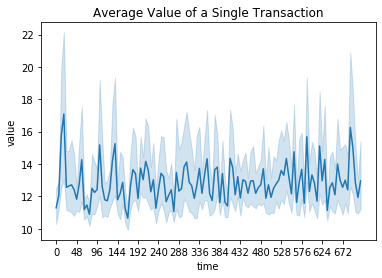

In [21]:
transactions_train = transcript_train[transcript_train['event'] == 'transaction'].drop('event', axis=1)
transactions_train['value'] = transactions_train['value'].apply(lambda d: d['amount'])
sns.lineplot(x='time', y='value', data=transactions_train)
plt.xticks(np.arange(0, 714, 48))
plt.title('Average Value of a Single Transaction')
plt.show()
transactions_train = transactions_train.pivot(index='person', columns='time').fillna(0)
transactions_train.columns = transactions_train.columns.droplevel()

(Not that we expected anything to change, but why not plot?)

In [51]:
RECEIVED = 1 << 0
VIEWED = 1 << 1
COMPLETED = 1 << 2

def agg(arr):
    out = 0
    for val in arr:
        if val == 'offer received':
            out |= RECEIVED
        elif val == 'offer viewed':
            out |= VIEWED
        else:
            out |= COMPLETED
    return out

def robust_access(d):
    try:
        return d['offer id']
    except:
        return d['offer_id']

offers_train = transcript_train[transcript_train['event'] != 'transaction']
offers_train['value'] = offers_train['value'].apply(lambda d: robust_access(d)) # Ah, the vagaries of formatting

offer_kinds = offers_train.pivot_table(index='person', columns='time', values='value', aggfunc=lambda arr: arr.to_numpy()[0], fill_value = 0)
offer_events = offers_train.pivot_table(index='person', columns='time', values='event', aggfunc=agg, fill_value = 0)
# offers_train = offers_train.pivot(index='person', columns='time')
# offers_train.columns = offers_train.columns.droplevel()

<ipython-input-51-9132159a17fc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offers_train['value'] = offers_train['value'].apply(lambda d: robust_access(d)) # Ah, the vagaries of formatting


Now we are struck primarily by people's ability to view the offer within the same 6 hour period they viewed the offer, which is all well and good except it makes our pivot messy. We'll have to aggregate, and python doesn't really care for enums. Still, we can use macros, right? Wrong! We've got problems with identity that aren't so straightforward. In the end, we're getting flustered over the format of an intermediate result. We can make two tables and throw them away freely.

In [54]:
offer_kinds.head()

time,0,6,12,18,24,30,36,42,48,54,...,660,666,672,678,684,690,696,702,708,714
person,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00116118485d4dfda04fdbaba9a87b5c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,0,fafdcd668e3743c1bb461111dcafc2a4,0,0,0,0,0,0,fafdcd668e3743c1bb461111dcafc2a4,...,5a8bc65990b245e5a138643cd4eb9837,0,0,0,0,0,0,0,0,0
0020ccbbb6d84e358d3414a3ff76cffd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now let's set out some conventions.

## Discrete time
Assume, when an offer is viewed, it is viewed at the start of the 6 hour period. Assume, when an offer is completed, it is at the end of the 6 hour period. In other words, all purchases made during a period are attributed to the offer in the corresponding cell.

In [56]:
purchases_cumsum = transactions_train.cumsum(axis=1)

In [57]:
purchases_cumsum

time,0,6,12,18,24,30,36,42,48,54,...,660,666,672,678,684,690,696,702,708,714
person,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,81.03,81.03,81.03,81.03,81.03,109.19,127.60,127.60,127.60,127.60
00116118485d4dfda04fdbaba9a87b5c,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,4.09,4.09,4.09,4.09,4.09,4.09,4.09,4.09,4.09,4.09
0011e0d4e6b944f998e987f904e8c1e5,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,79.46,79.46,79.46,79.46,79.46,79.46,79.46,79.46,79.46,79.46
0020c2b971eb4e9188eac86d93036a77,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,17.63,...,149.43,149.43,149.43,149.43,149.43,149.43,177.37,177.37,196.86,196.86
0020ccbbb6d84e358d3414a3ff76cffd,0.0,0.00,0.00,0.00,0.00,0.00,0.00,16.27,16.27,16.27,...,146.58,146.58,154.05,154.05,154.05,154.05,154.05,154.05,154.05,154.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,0.0,20.98,20.98,20.98,44.58,44.58,44.58,44.58,44.58,44.58,...,580.98,580.98,580.98,580.98,580.98,580.98,580.98,580.98,580.98,580.98
fff7576017104bcc8677a8d63322b5e1,0.0,0.00,0.00,0.00,0.00,0.00,5.55,5.55,5.55,5.55,...,26.14,26.14,26.14,26.14,26.14,26.14,29.94,29.94,29.94,29.94
fff8957ea8b240a6b5e634b6ee8eafcf,0.0,0.00,0.00,0.64,0.64,0.64,0.64,0.64,0.64,0.64,...,12.15,12.15,12.15,12.15,12.15,12.15,12.15,12.15,12.15,12.15


Thoughts: Evaluate impact of recent payments as a time series, not ARIMA but more linear regressions on different exponentially weighted windows.

Separately: just do correlograms? corrgrams? whatever, as a basic exploratory thing create different sums (for any offer, specific offers, offer categories, no offer, probably), and do correlations in addition to plots.

To restate the problem: offers are frequent. They come at an unknown cost and benefit to Starbucks (profit margin is exceedingly relevant), but while that problem would be easily solved with more data (and, in fact, can just be evaluated. If BOGO is a viable option, can we assume that profit margin is > 50%? almost! regardless, we can plot our return based on different profit margins and thresholds for selecting). The real key is how the offer influences customer behavior. We have a few different options:

1. It doesn't.
2. It puts them off.
3. It causes them to spend more money.
4. It causes them to frontload their spending.

Now, we'd like to avoid 1 and 2, which are (relatively?) easy. We should be able to identify people who spend more under the influence of the offer than they do independently. However, 3 and 4 is more difficult. The problem is that it's likely to be both, to some extent. If I have an offer for $2 if I spend $10 in a week, and I usually spend $8 a week, I may just get an extra coffee this week and hold back the next. This causes the actual effect to be smaller (I was likely going to spend the money anyway) and the perceived effect to be greater (I seem to be spending less when I'm not under the influence of the offer, which is perceived as baseline). I would much prefer having people who didn't receive the offer to compare as baseline, but if it turns out that spending is relatively insensitive or positively influenced by very recent spending I would be much less concerned. So, let's build some features!